In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import variation_dim
import time
import copy

import xarray as xr 
import pandas as pd
import numpy as np

def identity(rews,obs,acts):
    return rews

def shrinkdim(rews, obs, acts):
    return rews/variation_dim(obs)

def growdim(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def lessrough(rews, obs, acts):
    return rews*rough_measure(obs)

def morerough(rews, obs, acts):
    return rews/rough_measure(obs)


0 249.37414860725403


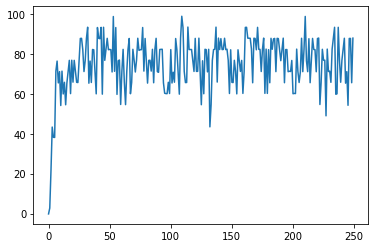

249.49365735054016


In [16]:
start = time.time()
torch.set_default_dtype(torch.float64)

num_trials = 1; num_epochs = 250
n_workers = 12; n_delta = 36; n_top = 18

exp_names = ['standard']
exp_fns = [identity]


# exp_names = ['standard','vardiv','varmul','rdiv','rmul']
# exp_fns = [identity, shrinkdim, growdim, lessrough, morerough]

#exp_names = ['standard','lessrough','morerough']
#exp_fns = [identity, lessrough, morerough]

num_experiments = len(exp_names)

data = xr.DataArray(np.zeros((num_experiments, num_trials, num_epochs)),
                    dims = ("Experiment", "Trial", "Epoch"),
                    coords = {"Experiment": exp_names})

post_data = xr.DataArray(np.zeros((num_experiments, num_trials, num_epochs)),
                    dims = ("Experiment", "Trial", "Epoch"),
                    coords = {"Experiment": exp_names})

policy_dict = {key:[] for key in exp_names}

env_name = "MountainCarContinuous-v0"
in_size = env.observation_space.shape[0]
out_size = env.action_space.shape[0]


policy = MLP(in_size,out_size,0,0)

for name, fn in zip(exp_names, exp_fns):
    for i in range(num_trials):
        policy, r_hist, lr_hist = ars(env_name, policy, num_epochs, n_workers=n_workers, n_delta=n_delta, n_top=n_top, postprocess=fn)
        print(i, time.time() - start)
        policy_dict[name].append(copy.deepcopy(policy))
        
        post_data.loc[name,i,:] = r_hist
        data.loc[name,i,:] = lr_hist
        plt.plot(lr_hist)

plt.show()
print(time.time() - start)

In [17]:
def do_rollout(env, policy):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        #env.render()
        #time.sleep(.02)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length, None

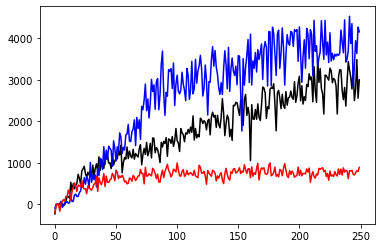

In [6]:
for thing in data[0,:,:]:
    plt.plot(thing, 'k')
for thing in data[1,:,:]:
    plt.plot(thing, 'b')
for thing in data[2,:,:]:
    plt.plot(thing, 'r')

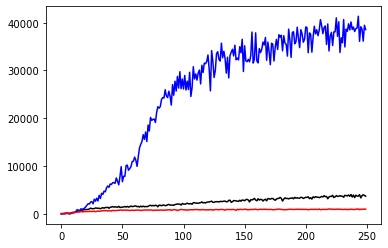

In [7]:
for thing in post_data[0,:,:]:
    plt.plot(thing, 'k')
for thing in post_data[1,:,:]:
    plt.plot(thing, 'b')
for thing in post_data[2,:,:]:
    plt.plot(thing, 'r')

reward:  tensor([98.9576], dtype=torch.float32)
vardim:  1.0013231971996515
roughness:  tensor(0.0168, dtype=torch.float32)


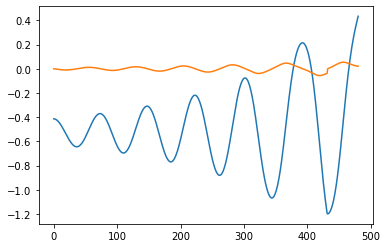

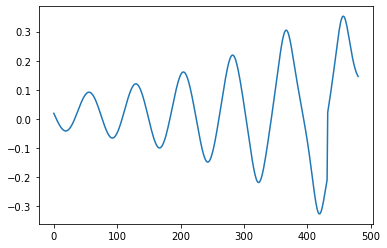

In [13]:
import gym
env = gym.make(env_name)
exp_name = "standard"; trial = 0
o,a,r,l,_ = do_rollout(env,policy_dict[exp_name][trial])
print("reward: ", sum(r))
print("vardim: ", variation_dim(o))
print("roughness: ", rough_measure(o))
plt.plot(o)
plt.figure()
plt.plot(a)

In [8]:
data = xr.DataArray(np.random.randn(2,3), dims=('x','y'), coords={'x':[10, 20]})
data.attrs['long_name'] = "yellow"


In [29]:
num_experiments=3
num_trials = 8
num_epochs=100
data = xr.DataArray(np.zeros((num_experiments, num_trials, num_epochs)),
                    dims = ("Experiment", "Trial", "Epoch"),
                    coords = {'Experiment': ['standard','vardiv','varmul']})

In [30]:
data.loc['standard',:]

<xarray.DataArray (Trial: 8, Epoch: 100)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])
Coordinates:
    Experiment  <U8 'standard'
Dimensions without coordinates: Trial, Epoch